EDA of feature importance based on first trained model, for competition Spaceship Titanic

https://www.kaggle.com/competitions/spaceship-titanic/overview

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import seaborn as sns
import matplotlib.pyplot as plt
import shap

In [2]:
is_kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', False)

In [3]:
if is_kaggle:
  # Input data files are available in the read-only "../input/" directory
  # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

  for dirname, _, filenames in os.walk('/kaggle/input'):
      for filename in filenames:
          print(os.path.join(dirname, filename))

  # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
  # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [32]:
base_path =  '/kaggle/input/spaceship-titanic' if is_kaggle else '/content/'

In [37]:
train_path = os.path.join(base_path, 'train.csv')
test_path = os.path.join(base_path, 'train_0001_spaceship_titanic_prediction_data.csv')
model_data_path = os.path.join(base_path, 'train_0001_spaceship_titanic_model_data.csv')

In [38]:
df = pd.read_csv(train_path)
df_test_processed = pd.read_csv(test_path)
df_model = pd.read_csv(model_data_path)

In [39]:
model_name = '/kaggle/input/train-0001-spaceship-titanic-baseline-rf/scikitlearn/spaceship_titanic_baseline_rf/1/train_0001_spaceship_titanic_baseline_rf.pkl' if is_kaggle else 'train_0001_spaceship_titanic_baseline_rf.pkl'

In [40]:
X = df_model.drop('Transported', axis=1)
y = df_model['Transported']

# Feature importance from trained Random Forest

In [9]:
import joblib

loaded_rf_model = joblib.load(model_name)

In [10]:
loaded_rf_model.feature_importances_

array([1.03005032e-01, 9.89299199e-02, 1.76120261e-03, 8.12048049e-02,
       7.76915592e-02, 6.38249699e-02, 9.58375628e-02, 8.34204858e-02,
       1.09432432e-01, 1.10926939e-01, 2.62757116e-02, 1.71892782e-03,
       4.39026878e-03, 5.53465382e-03, 2.66372509e-03, 1.09836742e-02,
       1.21747230e-02, 1.20220803e-02, 4.62399629e-05, 1.13995620e-02,
       1.20032059e-02, 2.34808751e-02, 1.52215904e-02, 9.68873425e-03,
       9.37256977e-03, 6.16031193e-03, 1.08282375e-02])

In [11]:
feature_importance_df = pd.DataFrame({
    "feature": X.columns,
    "importance": loaded_rf_model.feature_importances_
}).sort_values("importance", ascending=False)
feature_importance_df

,feature,importance
9,PassengerGroup,0.110927
8,CabinNum,0.109432
0,CryoSleep,0.103005
1,Age,0.098930
6,Spa,0.095838
7,VRDeck,0.083420
3,RoomService,0.081205
4,FoodCourt,0.077692
5,ShoppingMall,0.063825
10,GroupMember,0.026276


Build in Gini Importance for Random Forest

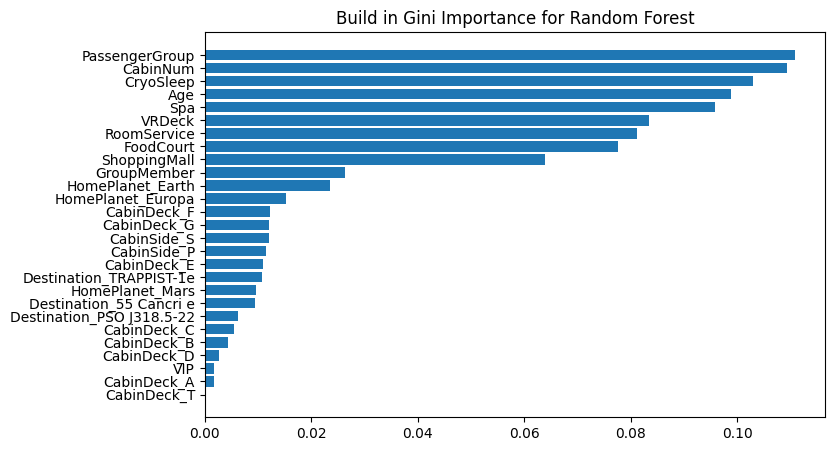

In [12]:
plt.figure(figsize=(8, 5))
plt.barh(feature_importance_df["feature"], feature_importance_df["importance"])
plt.gca().invert_yaxis()
plt.title("Build in Gini Importance for Random Forest")
plt.show()

Based on feature importance following columns were ranked as more important:



- PassengerGroup
- CabinNum
- CryoSleep
- Age
- Money spent on goods:
  RoomService, FoodCourt, ShoppingMall, Spa, VRDeck


Both PassengerGroup and CabinNum could be problematic, since Gini Coeffictient feature importance is prone to be biased toward features with many unique values.

PassengerGroup has 6217 and CabinNum has CabinNum unique values respectively.



We already saw that CryoSleep was important based on correlation
and based on this it should make sense to try combining money goods into a single value.

Age should be further studied for features engineering.

# Permutation importance from trained random forest


This is drop in prediction, when certain feature values are shuffled around.

In [13]:
df_model.columns

Index(['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'CabinNum', 'PassengerGroup', 'GroupMember',
       'CabinDeck_A', 'CabinDeck_B', 'CabinDeck_C', 'CabinDeck_D',
       'CabinDeck_E', 'CabinDeck_F', 'CabinDeck_G', 'CabinDeck_T',
       'CabinSide_P', 'CabinSide_S', 'HomePlanet_Earth', 'HomePlanet_Europa',
       'HomePlanet_Mars', 'Destination_55 Cancri e',
       'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'Transported'],
      dtype='object')

In [14]:
X.columns

Index(['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'CabinNum', 'PassengerGroup', 'GroupMember',
       'CabinDeck_A', 'CabinDeck_B', 'CabinDeck_C', 'CabinDeck_D',
       'CabinDeck_E', 'CabinDeck_F', 'CabinDeck_G', 'CabinDeck_T',
       'CabinSide_P', 'CabinSide_S', 'HomePlanet_Earth', 'HomePlanet_Europa',
       'HomePlanet_Mars', 'Destination_55 Cancri e',
       'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e'],
      dtype='object')

In [15]:
from sklearn.inspection import permutation_importance

result = permutation_importance(loaded_rf_model, X, y, n_repeats=10, random_state=42)

 Permutation importance randomly shuffles the values inside certain column.

In [16]:
perm_imp = pd.DataFrame({
    "feature": X.columns,
    "importance": result.importances_mean,
    "importance_std": result.importances_std,
}).sort_values("importance", ascending=False)

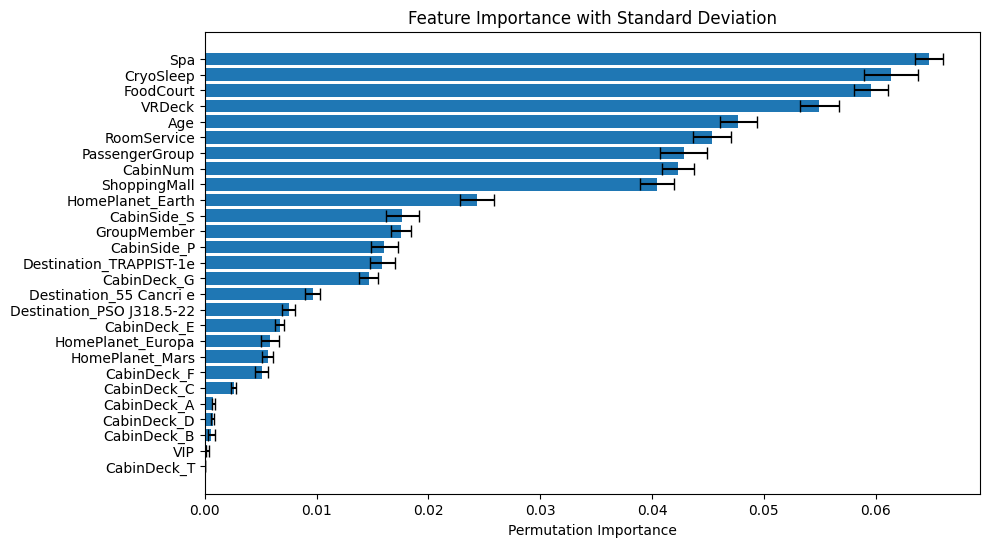

In [17]:
plt.figure(figsize=(10, 6))
plt.barh(
    perm_imp["feature"],
    perm_imp["importance"],
    xerr=perm_imp["importance_std"],
    capsize=4
)
plt.gca().invert_yaxis()  # highest importance at top
plt.xlabel("Permutation Importance")
plt.title("Feature Importance with Standard Deviation")
plt.show()

Based on feature importance following columns were ranked as more important:

- CryoSleep
- Money spent on goods: RoomService, FoodCourt, ShoppingMall, Spa, VRDeck
- Age
- PassengerGroup
- CabinNum


So same features as before, but PassengerGroup and CabinNum, values with a lot of distinct values dropped down a bit.

# SHAP values

Sample on subsample, since else it takes to long.

In [42]:
explainer = shap.TreeExplainer(loaded_rf_model)
shap_samples = df_test_processed.sample(2000)
shap_values = explainer.shap_values(shap_samples)

In [52]:
shap_samples.shape

(2000, 27)

In [53]:
shap_samples.shape

(2000, 27)

Most important features based on SHAP:

- Like before CryoSleep and Money spent on goods are at the top.
- HomePlanet_Earth gained in importance
- PassengerGroup and CabinNum dropped in importance.


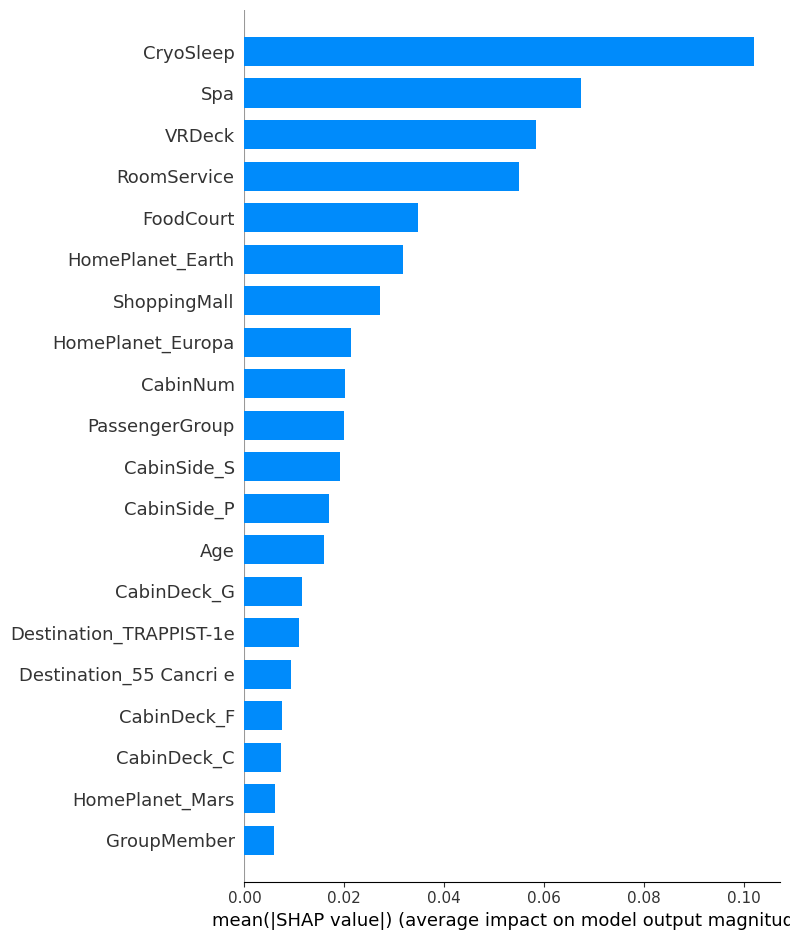

In [54]:
plt.figure()
shap.summary_plot(shap_values[:, :, 1], shap_samples, plot_type="bar")
plt.show()

Summary plot how data actually contributes to prediction.

New findings:
- CryoSleep is still the most important feature.

- Money goods variables are important but not in the same direction, as previously assumed.

  Spa, VRDeck and RoomService have opposite influence than FoodCourt and ShoppingMaill. So while combining them could make sense as said, dropping then entirely does not seem sensible anymore.

- Where passenger boarded like Earth or Europa also plays some role in prediction.
- CabinNum and PassengerGroup are slightly less importance in prediction and don't have direct influence in prediction.

- Age dropped in signifigance and does not clear direction in prediction. It should be more examined compared to other values.

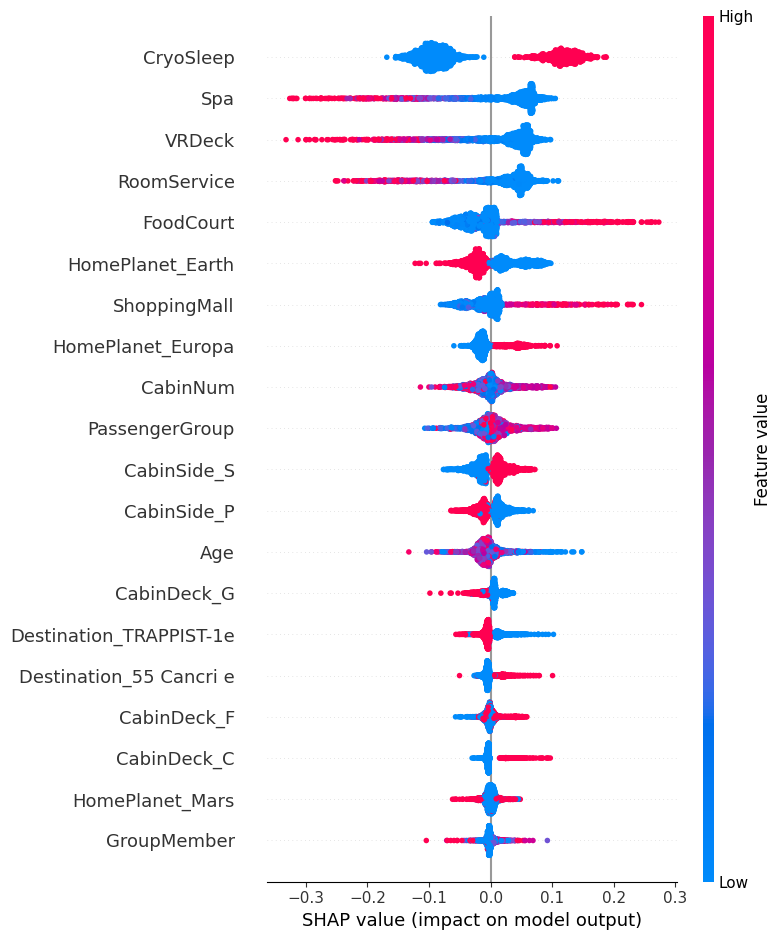

In [55]:
plt.figure()
shap.summary_plot(shap_values[:, :, 1], shap_samples)
plt.show()

In [60]:
df_test_processed.columns

Index(['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'CabinNum', 'PassengerGroup', 'GroupMember',
       'CabinDeck_A', 'CabinDeck_B', 'CabinDeck_C', 'CabinDeck_D',
       'CabinDeck_E', 'CabinDeck_F', 'CabinDeck_G', 'CabinDeck_T',
       'CabinSide_P', 'CabinSide_S', 'HomePlanet_Earth', 'HomePlanet_Europa',
       'HomePlanet_Mars', 'Destination_55 Cancri e',
       'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e'],
      dtype='object')

So no dependence plots with findings were found.
It is interested that for CryoSleep most predictive feature,
Home planet Mars, which is not important feature,
was selected as the feature that complements predictions the most.

While some pattern could be seen, this could also mean that CryoSleep feature is independent, is predictive on its own.

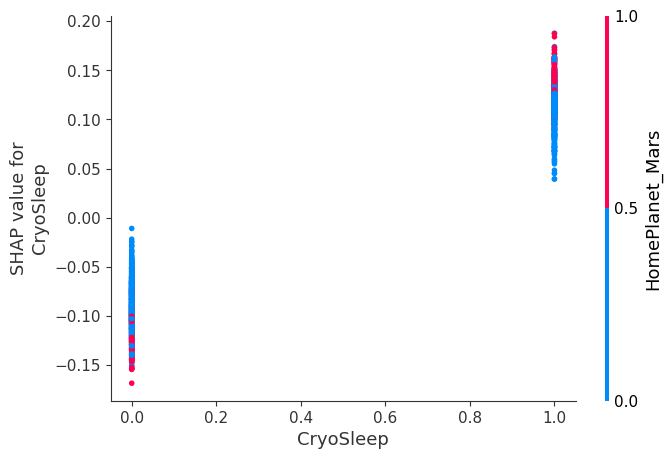

In [94]:
shap.dependence_plot("CryoSleep", shap_values[:, :, 1], shap_samples)